# Seasonality Detection for Bangkok PM2.5 Data using Fast Fourier Transform

## Introduction

This project is focusing on using **Fast Fourier Transform (FFT)** to detect the seasonality in **Bangkok PM2.5 Data** in [Kaggle](https://www.kaggle.com/datasets/chadapamettapun/bangkok-airquality). The propose of this project is to learn about how signal processing techniques can be used in Time Series Data and detect the cycle of **Yearly PM2.5 Crisis in Bangkok**.

## Fast Fourier Transform

Suppose we have some countinuous wave function, we can extract the wave function into multiple frequencies using Fourier Transform, but for discrete data like sounds, or in this case, air quality data, we cannot use continuous Fourier Transform right away. So we use the discrete version of fourier transform which is **Fast Fourier Transform** to detect the frequencies of the Time Series Data.

## FFT in Seasonality Detection Procedure

From [this precious video](https://www.youtube.com/watch?v=spUNpyF58BY&vl=en) by 3blue1brown, the Continuous Fourier Transform can be written as:

$$
F(\omega) = \int_{t_1}^{t_2} f(t)e^{-2i\omega t} dt
$$

Now considering Discrete type of Fourier Transform:

$$
X_k = \sum x_n \cdot e^{- 2\pi i \cdot \frac{kn}{N}}
$$

We then consider only real part of the equation

$$
X_k = \sum x_n \cdot \cos(- 2\pi i \cdot \frac{kn}{N})
$$

Where $X_k$ is the intensity of the frequency. Now consider **(Real) Inverse Discrete Fourier Transform**:

$$
x_n = \frac{1}{N} \sum X_k \cdot \cos(2\pi i \frac{kn}{N})
$$

We then define the seasonality

$$
s = \frac{N}{\text{argmax}_{k} X_k}
$$

and the intensity of seasonality

$$
\hat{X}_k = \max X_k
$$

Our seasonality equation then can be reduced to

$$
x_n \approx \frac{\hat{X}_k}{N} \cdot \cos(2\pi i \frac{n}{s})
$$

This is how we will obtain the seasonality of the time series data

## Data Transformation

We wouldn't put the Time Series Data in the Fast Fourier Transform algorithm right away, we use the following transformation of the data first:

### Min-Max Scaling

The sklearn's **Min-Max Scaler** formula can be written as

$$
x_{mms} = \frac{x - \min{x}}{\max{x} - \min{x}}
$$

### Subtract by mean

Then after we get our Min-Max Scaler Values, we subtract them by mean

$$
x_{transform} = x_{mms} - \bar{x}_{mms}
$$

We will input the $x_{transform}$ into our FFT procedure and got the cosine approximation in return.

### Inverse Transformation

With the following transformations, the way to get the original data is

$$
x = (x_{transform} + \bar{x}_{mms}) \cdot (\max x - \min x) + \min x
$$

Where $x_{transform}$ is the transformed data, whether from original data or from cosine transformation.

## Code

### Import Necessary Libraries

We will use `pandas`, `numpy`, `matplotlib` to deal with analytics, transformation and visualization and `datetime` to deal with time series data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### Import Necessary Utilities

We have `utils.Air_Quality_Dataset` class to deal with Dataset which is in Text, this class will convert the text to readable `pandas.DataFrame` which we will use to deal with time series.

In [2]:
from utils import Air_Quality_Dataset

### Exploratory Analysis

We then get the Air Quality Data from **Bangkok**

In [3]:
bangkok_air_quality = Air_Quality_Dataset("dataset/Bangkok.txt")

We observe the first 5 records

In [4]:
bangkok_air_quality.data.head()

,year,month,day,utc_hr,pm25,pm10mask,retrospective
0,2016,3,3,8,65.2,1.0,0
1,2016,3,3,9,65.2,1.0,0
2,2016,3,3,10,64.9,1.0,0
3,2016,3,3,11,64.9,1.0,0
4,2016,3,3,12,38.4,1.0,0


We then copy the data, convert the `year`, `month`, `day` and `utc_hr` columns into `datetime`

In [5]:
bangkok_air_data = bangkok_air_quality.data.copy()

In [6]:
bangkok_air_data['datetimeutc'] = bangkok_air_data.apply(lambda x: datetime(int(x['year']), int(x['month']), int(x['day']), int(x['utc_hr'])), axis=1)

In [7]:
bangkok_air_data.head()

,year,month,day,utc_hr,pm25,pm10mask,retrospective,datetimeutc
0,2016,3,3,8,65.2,1.0,0,2016-03-03 08:00:00
1,2016,3,3,9,65.2,1.0,0,2016-03-03 09:00:00
2,2016,3,3,10,64.9,1.0,0,2016-03-03 10:00:00
3,2016,3,3,11,64.9,1.0,0,2016-03-03 11:00:00
4,2016,3,3,12,38.4,1.0,0,2016-03-03 12:00:00


We then plot the time series data

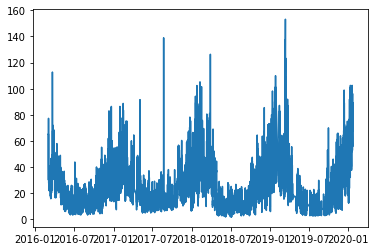

In [8]:
plt.plot(bangkok_air_data['datetimeutc'], bangkok_air_data['pm25'])

We can observe the Seasonality of the data approximately every year.

### Exponential Smoothing

We can define Exponential Smoothing as follows (excuse my functional programming):

In [9]:
def exponential_smoothing(alpha):
    def exp_smooth(x1, x2):
        return (1 - alpha) * x1 + alpha * x2
    return exp_smooth

We then accumulate our exponential smoothing function to all data with $\alpha = 0.01$

In [10]:
bangkok_air_data['pm25_exp_smooth'] = np.frompyfunc(exponential_smoothing(0.01), 2, 1)\
                            .accumulate(bangkok_air_data['pm25'], dtype=object)\
                            .astype(float)


and then observe the trend again

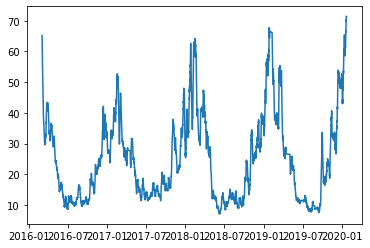

In [11]:
plt.plot(bangkok_air_data['datetimeutc'], bangkok_air_data['pm25_exp_smooth'])

We then observe the residuals of our exponential smoothing

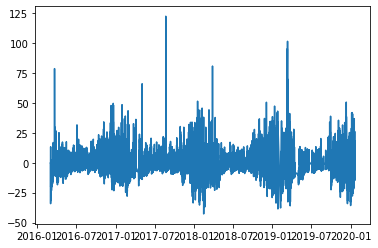

In [12]:
residual = bangkok_air_data['pm25'] - bangkok_air_data['pm25_exp_smooth']
plt.plot(bangkok_air_data['datetimeutc'], residual)

### Fast Fourier Transform of the daily PM2.5 Data

#### Importing Necessary Modules and Data Preprocessing

We import the `rfft` function from `numpy.fft`. This function calculates the FFT of real inputs

In [13]:
from numpy.fft import rfft

We then obtain the daily average of PM2.5 using the following procedure

In [14]:
date_and_pm = bangkok_air_data[['datetimeutc', 'pm25']]

In [15]:
date_and_pm['date'] = bangkok_air_data['datetimeutc'].apply(lambda x: datetime(x.year, x.month, x.day))

C:\Users\HP\AppData\Local\Temp\ipykernel_7196\2141231619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_and_pm['date'] = bangkok_air_data['datetimeutc'].apply(lambda x: datetime(x.year, x.month, x.day))


In [16]:
daily_pm25 = date_and_pm.groupby('date').mean()

and plot the values of daily PM2.5 data

<AxesSubplot:xlabel='date'>

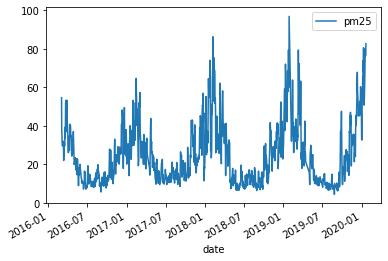

In [17]:
daily_pm25.plot()

#### Data Transformation

We then use `MinMaxScaler` from `sklearn.preprocessing` to scale all data to range $[0,1]$

In [18]:
from sklearn.preprocessing import MinMaxScaler

daily_pm25['pm25_scaled'] = MinMaxScaler(feature_range=(0, 1)).fit_transform(daily_pm25['pm25'].values.reshape(-1, 1)).flatten()
daily_pm25

,pm25,pm25_scaled
date,,
2016-03-03,54.633333,0.543018
2016-03-04,35.937500,0.341040
2016-03-05,35.125000,0.332262
2016-03-06,30.041667,0.277345
2016-03-07,29.608333,0.272664
...,...,...
2020-01-17,73.121739,0.742755
2020-01-18,80.030435,0.817392
2020-01-19,76.491304,0.779157


Then subtract them by the mean of the scaled data

In [19]:
x_minus_xbar = daily_pm25['pm25_scaled'] - np.mean(daily_pm25['pm25_scaled'])

#### Fast Fourier Transform and Seasonality Detection

We then perform the FFT of the data and argsort the magnitude of the FFT results to obtain the frequency

In [20]:
fft_daily = rfft(x_minus_xbar).real
sort_magnitude = np.argsort(fft_daily)[::-1][:1]
sort_magnitude

array([4], dtype=int64)

The frequency with the highest magnitude in this data is 4, that means seasonality happens 4 times in this data. Hence we observe the seasonality:

In [21]:
len_data = len(daily_pm25['pm25'])

seasonality = len_data / (sort_magnitude)

seasonality

array([333.5])

We can see that the seasonality is 333.5. In other words, the **PM2.5 Crisis** happens every 333.5 days approximately

### Inverse Transform and Comparison

We then perform the inverse transform to obtain the Seasonality Equation

In [22]:
def get_cos_period(n):
    return np.arange(len_data) / (len_data) * 2 * np.pi * n

Then plot both original data and approximated data from FFT to visualize

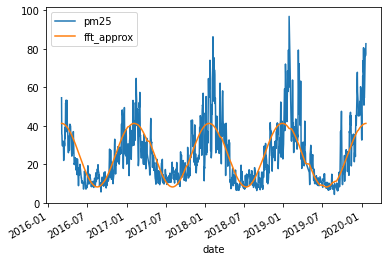

In [23]:
fft_approx = np.zeros(len_data)

for idx in sort_magnitude:
    fft_approx += np.cos(get_cos_period(idx)) * np.abs(fft_daily[idx]) / len_data * 2

daily_pm25['fft_approx'] = (fft_approx + np.mean(daily_pm25['pm25_scaled'])) * (np.max(daily_pm25['pm25']) - np.min(daily_pm25['pm25'])) + np.min(daily_pm25['pm25'])
daily_pm25[['pm25', 'fft_approx']].plot()
plt.show()

#### Constructing an Approximate Equation

We then obtain the necessary values to Construct our Approximate Equation for PM2.5 in Bangkok

In [24]:
np.mean(daily_pm25['pm25_scaled'])

0.22046843887262166

In [25]:
np.max(daily_pm25['pm25']) - np.min(daily_pm25['pm25'])

92.56376811594203

In [26]:
np.min(daily_pm25['pm25'])

4.369565217391305

In [27]:
fft_daily[sort_magnitude]

array([119.02813538])

Hence, the Approximate Formula for Concentration of PM2.5 in Bangkok is

$$
f(t) \approx \left(\frac{238.06}{1334} \cdot \cos \left(\frac{2\pi t}{333.5} \right) + 0.22 \right) \cdot 92.56 + 4.37
$$

Which can be simplified to

$$
f(t) \approx 16.52 \cos(0.019 t) + 24.73
$$

Where $t$ is **Duration from 3rd March 2016 (days)**

### Residual Analysis and Inferences

We then obtain the residuals then plot the histogram

In [28]:
daily_pm25['fft_residual'] = daily_pm25['pm25'] - daily_pm25['fft_approx']

(array([  9., 128., 428., 509., 168.,  50.,  24.,  13.,   4.,   1.]),
 array([-28.33103952, -19.66883658, -11.00663365,  -2.34443071,
          6.31777223,  14.97997517,  23.64217811,  32.30438105,
         40.96658399,  49.62878693,  58.29098986]),
 <BarContainer object of 10 artists>)

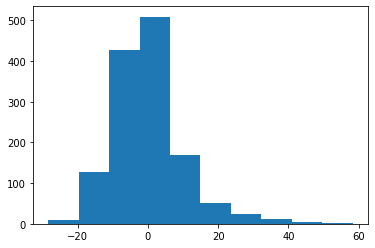

In [29]:
plt.hist(daily_pm25['fft_residual'])

Then Perform the **Shapiro-Wilk Test** for Normal Distribution

In [30]:
from scipy.stats import shapiro

shapiro(daily_pm25['fft_residual'])

ShapiroResult(statistic=0.9381633400917053, pvalue=3.9600643892695644e-23)

According to p-value, the residual is not a Normal Distribution.

We then plot the residual over time.

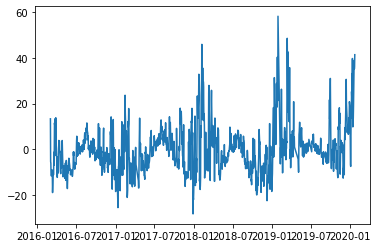

In [31]:
plt.plot(daily_pm25['fft_residual'])

The Seasonality Detection using Fourier Transform may not be a robust way to approximate the equation of the time series data. But we still can observe some seasonality trends from the time series data.

---